In [89]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
CaseName_Base = 'RTS24_mod1'
CaseName_ByStages = CaseName_Base + '_ByStages_nc'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_F = 'F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
Folder_G = 'G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.Operation_cost'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.Representative_days_based_on_RES_and_Demand'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_JF = 'J.Full_year_operational_cost\\Results\\F.Representative_days_based_on_Line_Benefit_NN_OC_fy_1'
Folder_JG = 'J.Full_year_operational_cost\\Results\\G.Representative_days_based_on_Line_Benefit_NN_OC_fy_2'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.Investments_per_hour'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.Cont_Investments_per_hour'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_F: "NN_LB1",
                 Folder_G: "NN_LB2",
                 Folder_K: "Hourly_inv",
                 Folder_L: "CHI",
                 Folder_JB: "OPC_fy",
                 Folder_JD: "R&D_fy",
                 Folder_JE: "OPT_LB_fy",
                 Folder_JF: "NN_LB_fy1",
                 Folder_JG: "NN_LB_fy2",
                 Folder_JK: "HI_fy",
                 Folder_JL: "CHI_fy"
                }

In [91]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
#     df['Category2'] = cat2
#     df['Category3'] = cat3
    df['Number of clusters'] = ncluster
    df = df.reset_index()
#df = df.reset_index().set_index(['CaseName', 'Category1', 'Category2', 'Category3', 'Category4'])
    # df = df.set_index('CaseName', append=True)
    return df
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df
def get_aggregated_curt(df_curt):
    wind = df_curt.pivot_table(values = "MW", index = "LoadLevel",columns = "Unit").filter(like = "WIND").sum().sum()
    solar = df_curt.pivot_table(values = "MW", index = "LoadLevel",columns = "Unit").filter(like = "PV").sum().sum()
    return wind,solar
def get_weighted_aggregated_curt(df_curt,df_weights): 
    merged_df = df_curt.merge(df_weights,how = "left",on = "LoadLevel")
    #merged_df.pivot_table(values = "Weight",index = "LoadLevel",aggfunc= "mean")
    merged_df["MW_weighted"] = merged_df["MW"] * merged_df["Weight"]
    wind = merged_df.pivot_table(values = "MW_weighted", index = "LoadLevel",columns = "Unit").filter(like = "WIND").sum().sum()
    solar = merged_df.pivot_table(values = "MW_weighted", index = "LoadLevel",columns = "Unit").filter(like = "PV").sum().sum()

    return wind,solar


In [92]:
result = "RESCurtailment"
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]

folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_JB,Folder_JD,Folder_JE,Folder_JL]
folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["RESCurtailment"]

results_dfs = dict()
weights_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()

    for folder in folders: 
        results_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

In [82]:
df_curt = results_dfs["RESCurtailment"]['D.Representative_days_based_on_RES_and_Demand'][10]
df_weights = weights_dfs['RESCurtailment']["D.Representative_days_based_on_RES_and_Demand"][10]
merged_df = df_curt.merge(df_weights,how = "left",on = "LoadLevel")
#merged_df.pivot_table(values = "Weight",index = "LoadLevel",aggfunc= "mean")
merged_df["MW_weighted"] = merged_df["MW"] * merged_df["Weight"]

5788539.338423419

In [93]:
result = "RESCurtailment"
agg_curt_dict = dict()
agg_results = pd.DataFrame()
i=0
for folder in folders:
    agg_curt_dict[folder] = dict()
    for nb_clusters in nbs_clusters: 
        if folder.startswith("J") or folder.startswith("A"):
            aggregated_weighted_curt = aggregatedcurt = get_aggregated_curt(results_dfs[result][folder][nb_clusters])
        else: 
            aggregatedcurt = tuple([curt*(8736/nb_clusters)for curt in  get_aggregated_curt(results_dfs[result][folder][nb_clusters])])
            aggregated_weighted_curt = get_weighted_aggregated_curt(results_dfs[result][folder][nb_clusters],weights_dfs[result][folder][nb_clusters])
        agg_curt_dict[folder][nb_clusters] = aggregatedcurt
        row = pd.DataFrame({"Clustering method":category_dict[folder] ,
                            "Number of clusters": nb_clusters,
                            "WIND_curt": aggregatedcurt[0],
                            "PV_curt": aggregatedcurt[1],
                            "WIND_curt_w": aggregated_weighted_curt[0],
                            "PV_curt_w": aggregated_weighted_curt[1]
                           },index = [i])
        i+=1
        agg_results = pd.concat([agg_results,row])
agg_results["Total_curt"] = agg_results["WIND_curt"] + agg_results["PV_curt"]
agg_results["Total_curt_w"] = agg_results["WIND_curt_w"] + agg_results["PV_curt_w"]
agg_results.set_index("Clustering method",inplace=True)

In [98]:
agg_results.loc["OPC"]

,Number of clusters,WIND_curt,PV_curt,WIND_curt_w,PV_curt_w,Total_curt,Total_curt_w
Clustering method,,,,,,,
OPC,10,2.679441e+06,2.679876e+06,4.501473e+06,4.420897e+06,5.359317e+06,8.922370e+06
OPC,20,6.572779e+06,2.330889e+06,1.052867e+07,4.383117e+06,8.903668e+06,1.491179e+07
OPC,30,8.825207e+06,4.552063e+06,1.692031e+07,9.216181e+06,1.337727e+07,2.613649e+07
OPC,40,6.708222e+06,3.062269e+06,1.266224e+07,6.521454e+06,9.770491e+06,1.918370e+07
OPC,50,8.952595e+06,2.594382e+06,1.844110e+07,5.881321e+06,1.154698e+07,2.432242e+07
OPC,60,6.206826e+06,2.215404e+06,1.394092e+07,5.573404e+06,8.422230e+06,1.951432e+07
OPC,70,8.464027e+06,2.604582e+06,1.741457e+07,6.800630e+06,1.106861e+07,2.421520e+07
OPC,80,7.852236e+06,2.133271e+06,1.516185e+07,4.958759e+06,9.985507e+06,2.012061e+07
OPC,90,7.884752e+06,1.951788e+06,1.601432e+07,5.326378e+06,9.836540e+06,2.134070e+07


<Axes: xlabel='Number of clusters', ylabel='Total_curt'>

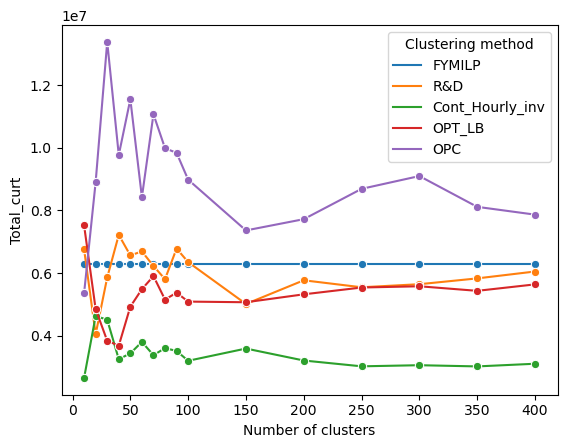

In [103]:
#Regular line plots
y = "Total_curt"
x = "Number of clusters"
rf = agg_results.loc[["FYMILP","R&D_fy","CHI_fy","OPT_LB_fy","OPC_fy"]]
rf = agg_results.loc[["FYMILP","R&D","CHI","OPT_LB","OPC"]]
#rf = agg_results
sns.lineplot(data = rf,x = x, y = y,hue = "Clustering method",marker = "o")